In [16]:
import numpy as np

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline

from imutils.object_detection import non_max_suppression

import cv2

In [8]:
os.listdir('.')

['.DS_Store',
 'images',
 'Untitled.ipynb',
 'source',
 'README.md',
 '.gitignore',
 'frozen_east_text_detection.pb',
 '.ipynb_checkpoints',
 'EAST.ipynb',
 '.git']

In [103]:
image = cv2.imread('images/6.jpg')
orig = image.copy()
(H, W) = image.shape[:2]

(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [104]:
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
]

In [105]:
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] text detection took 0.227724 seconds


In [106]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
    
	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < 0.5:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])
        
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes

rois = []
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    
    rois.append(
        orig[startY: endY, startX:endX]
    )
    
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

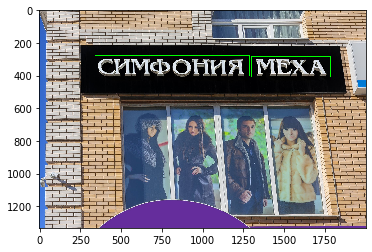

In [114]:
plt.imshow(
    cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
)

In [108]:
cv2.imwrite('output.jpg', orig)

True